<a href="https://colab.research.google.com/github/lmarchyok/ICEsat-2/blob/main/Solar_Elevation_vs_Saturation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd
import os
import numpy as np
import zipfile
import h5py
import matplotlib.pylab as plt

In [3]:
data_dir = '/content/drive/MyDrive/ICEsat-2/ICEsat-2_data_downloads/OR/Oregon_Data/5000003164021.zip'

with zipfile.ZipFile(data_dir) as zp:
   zp.extractall()

In [27]:
h5_file = '/content/225152451/processed_ATL03_20191005064105_01280502_005_01.h5'

with h5py.File(h5_file, 'r') as f1:
#    print(list(f1.keys()))
    gt1l = f1.get('gt1l')
    gt1l_arr = np.array(gt1l)
    gt1l_data = gt1l.get('geolocation')
    gt1l_data_arr = np.array(gt1l_data)
    solar_elevation = gt1l_data.get('solar_elevation')
    saturation = gt1l_data.get('full_sat_fract')
    solar_elevation_arr = np.array(solar_elevation)
    saturation_arr = np.array(saturation)
#    print(gt1l_arr)
#    print(gt1l_data_arr)
    print(solar_elevation_arr)
    print(saturation_arr)
    print(saturation_arr.max())
    print(solar_elevation_arr.shape)

[-47.86735  -47.86718  -47.867027 ... -47.44717  -47.447014 -47.44687 ]
[0. 0. 0. ... 0. 0. 0.]
0.1875
(2658,)


In [28]:
def plot_sat_vs_sol_elev(title='Solar Elevation over 700m', selims='auto'):
    if selims=='auto':
        lower = np.nanmin(saturation_arr)
        upper = np.nanmax(saturation_arr)
        serange = upper - lower
        selims = [lower - 0.2*serange, upper + 0.1*serange]

    lat_lower = np.nanmin(solar_elevation_arr)
    lat_upper = np.nanmax(solar_elevation_arr)
    latrange = lat_upper - lat_lower
    latlims = [lat_lower - 0.2 * latrange, lat_upper + 0.1 * latrange]

    print(lat_lower)
    print(lat_upper)

    fig = plt.figure(figsize=(9, 6), dpi=80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    solar_elevation = solar_elevation_arr
    saturation = saturation_arr
    ax.set_title(title)
    ax.set_xlabel('solar_elevation (degrees)')
    ax.set_ylabel('saturation (percentage)')

    atl03_plot = ax.scatter(solar_elevation, saturation, s=10,c='k',edgecolors='none',label='gt1l')
    ax.legend(handles=[atl03_plot], loc='lower left')
    ax.set_xlim(latlims)
    ax.set_ylim(selims)

    if not os.path.exists('figs'):
        os.makedirs('figs')
    fn = 'figs/atl03_plot_solar_elevation.png'
    plt.savefig(fn, dpi=150)

-47.86735
-47.44687


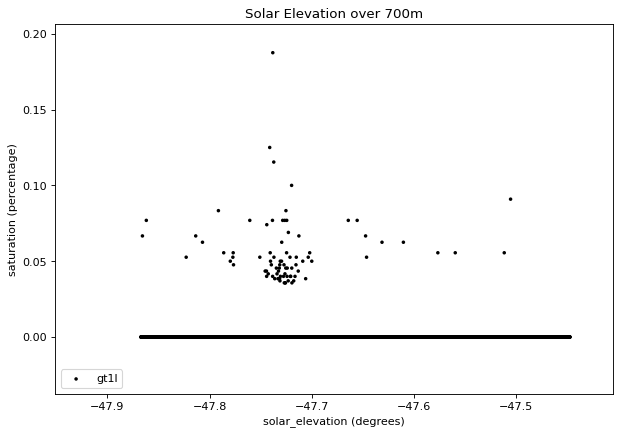

In [29]:
if __name__ == '__main__':
    plot_sat_vs_sol_elev()